### Derive cross-

- Extract pngs from mp4 video
    - **Define optimal FPS**
- Preprocessing (Apply for each frame)
    - **(???)Estimtion of angular resolution**
    - **Projection on ground grid (reprojection)**
        - Create ground grid (define resolution dx == dy)
        - Interpolate from drone grid to ground
    - **Correct for the glint (Normalization)**
        - Fit 2D gaussian filter
        - Devide intensity by gaussian filter  
        - (???) Crop
- Extract cross-spectra (for each consequent pair of frames)
- Average cross-spectra derived from each pair
- Plot directional frequency spectra

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from numpy.fft import fft2, fftshift, ifft2, fftfreq

In [1]:
def projection(x, y, h, alpha):
    
    x_proj = np.tan(x*alpha) * h
    y_proj = np.tan(y*alpha) * h
    
    return x_proj, y_proj

## Calibration with the boat

Size of the boat is 622 pixels
Image resolution: 0.16 meters
angle resolution of the camera: 0.0005251875187021264 radians (~0.03 degrees)


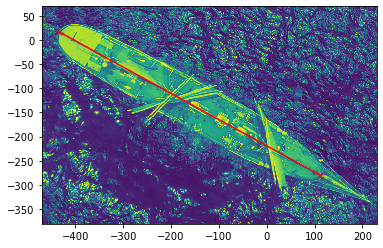

In [6]:
if True:
    
    # Read image of the boat for calibration
    file_img = 'test.png' 
    rgb_img = imread(file_img)
    
    # Image coordinates
    img_shape = rgb_img[:,:,0].shape
    y_img = np.arange(-img_shape[0]/2, img_shape[0]/2)
    x_img = np.arange(-img_shape[1]/2, img_shape[1]/2)

    # Constants
    d_boat = 98 # boat length in meters (to be verified!)
    h_drone = 300 # drone's altitude above sea surface in meters
    
    # zoom on boat
    imin, imax = 700, 1150 
    jmin, jmax = 1450, 2150
    plt.pcolormesh(x_img[jmin:jmax],y_img[imin:imax],rgb_img[imin:imax,jmin:jmax,0])

    # get boat length (in pixels)
    i1,j1 = 1097,1485 
    i2,j2 = 800, 2032
    plt.plot((x_img[j1], x_img[j2]), (y_img[i1], y_img[i2]), c='r', marker='x')
    npix_boat = int(round(np.sqrt((y_img[i2] - y_img[i1])**2 + (x_img[j2] - x_img[j1])**2),0))
    print(f'Size of the boat is {npix_boat} pixels')
    
    # image resolution in meters (considering dx==dy)
    res_img = d_boat/npix_boat
    print(f'Image resolution: {np.array(res_img).round(2)} meters')
    
    # angle resolution of the camera, in radians (to be used to correct other images)
    alpha = np.arctan(res_img/h_drone)
    print(f'angle resolution of the camera: {alpha} radians (~{np.degrees(alpha).round(2)} degrees)')

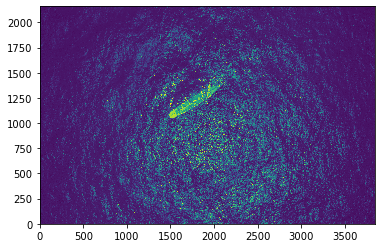

In [16]:
plt.pcolormesh(rgb_img[::-1,:,0])

## Image processing

In [38]:
file_img = 'DJI_03981.png' # input image file name

h_drone = 300 # drone's altitude in meters 

band = 0 # band of image (0,1, or 2)

subsampling = 2 # subsampling of input image

alpha = 0.0005251 # angle resolution of the camera (in radians)

res_reg = 2 # resolution of projected image (in meters)


#### Get data

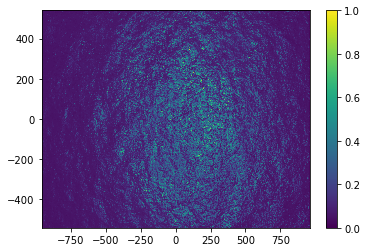

In [39]:
# Read image file
rgb_img = imread(file_img)

# image values
data = rgb_img[:,:,band]

# subsampling
data = convolve2d(data,np.ones((subsampling,subsampling))/subsampling**2)
data = data[::subsampling, ::subsampling]

# image coordinates
img_shape = data.shape
y_img = np.arange(-img_shape[0]/2, img_shape[0]/2)
x_img = np.arange(-img_shape[1]/2, img_shape[1]/2)


plt.pcolormesh(x_img, y_img, data, vmin=0, vmax=1)
plt.colorbar()

#### Project to ground coordinates

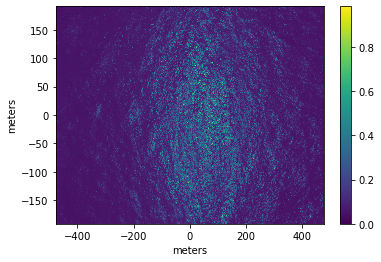

In [40]:
# projection
x_grnd, y_grnd = projection(x_img, y_img, h=h_drone, alpha=subsampling*alpha)

plt.pcolormesh(x_grnd, y_grnd, data)
plt.xlabel('meters')
plt.ylabel('meters')
plt.colorbar()

#### Interpolate to regular grid

In [41]:
# Regular-grid coordinates
x_reg = np.arange(+x_grnd[0], +x_grnd[-1], res_reg)

y_reg = np.arange(+y_grnd[0], +y_grnd[-1], res_reg)

print(y_reg.size,x_reg.size)

192 476


In [42]:
# Croping
Ny, Nx = 1, 1

while 2*Ny<y_reg.size:
    Ny *= 2
while 2*Nx<x_reg.size:
    Nx *= 2

x_reg = x_reg[int(x_reg.size//2 - Nx//2): int(x_reg.size//2 + Nx//2)]
y_reg = y_reg[int(y_reg.size//2 - Ny//2): int(y_reg.size//2 + Ny//2)]

print(y_reg.size,x_reg.size)

128 256


In [ ]:
# Bilinear interpolation

x2d_grnd,y2d_grnd = np.meshgrid(x_grnd,y_grnd)
x2d_reg,y2d_reg = np.meshgrid(x_reg,y_reg)


data_interp = griddata((x2d_grnd.flatten(), y2d_grnd.flatten()), 
                    data.flatten(),
                    (x2d_reg.flatten(),y2d_reg.flatten())).reshape(x2d_reg.shape)

plt.pcolormesh(x2d_reg, y2d_reg, data_interp)
plt.xlabel('meters')
plt.ylabel('meters')
plt.colorbar()

#### Correct for sun glint 

In [ ]:
Ny, Nx = data_interp.shape

In [ ]:
glint = gaussian_filter(data_interp,sigma=80)
plt.pcolormesh(glint)
plt.colorbar()

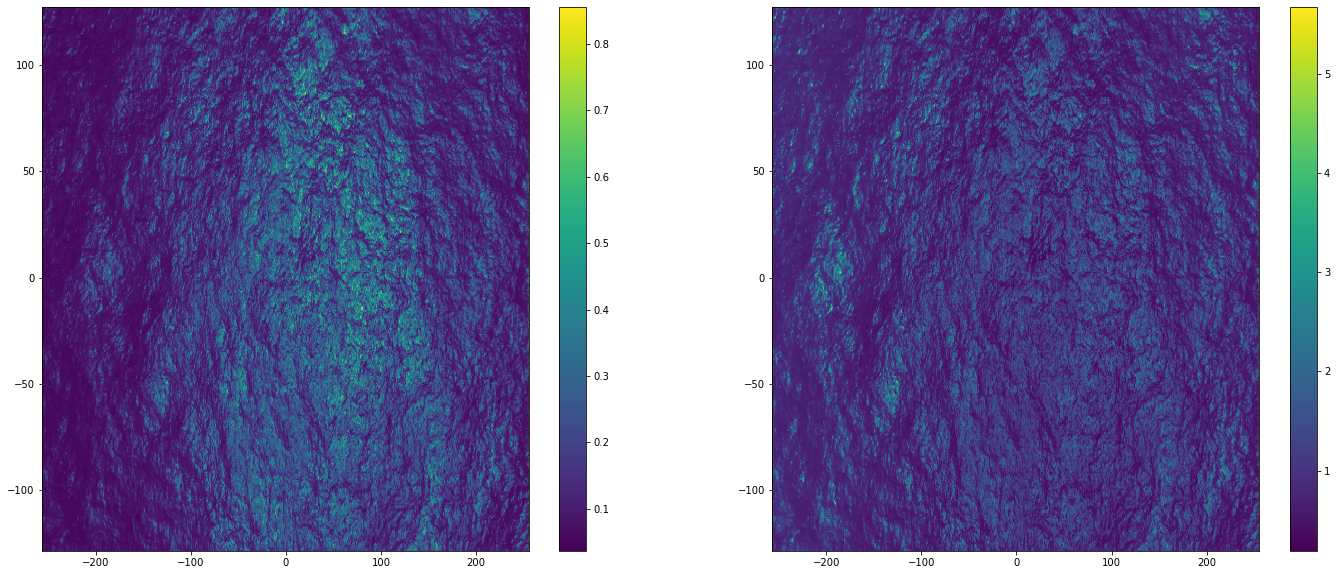

In [37]:
fig,axes = plt.subplots(1,2, figsize=(24,10))

im = axes[0].pcolormesh(x2d_reg, y2d_reg, data_interp)
plt.colorbar(im, ax=axes[0])

im = axes[1].pcolormesh(x2d_reg, y2d_reg, data_interp/glint)#,vmin=data_interp.min(),vmax=data_interp.max())
plt.colorbar(im, ax=axes[1])

## Grab all processing steps in one function

In [3]:
def process_one_frame(file_img, h_drone, band=1, subsampling=1, alpha=0.0005251, res_reg=1, kernel_size=40):
    
    #########################
    # Get data
    #########################
    # Read image file
    rgb_img = imread(file_img)
    # image values
    data = rgb_img[::subsampling,::subsampling,band]
    # image coordinates
    img_shape = data.shape
    y_img = np.arange(-img_shape[0]/2, img_shape[0]/2)
    x_img = np.arange(-img_shape[1]/2, img_shape[1]/2)
    
    #########################
    # Get data
    #########################
    x_grnd, y_grnd = projection(x_img, y_img, h=h_drone, alpha=subsampling*alpha)
    
    #########################
    # Interpolate to regular grid
    #########################
    # Regular-grid coordinates
    x_reg = np.arange(x_grnd[0],x_grnd[-1],res_reg)
    y_reg = np.arange(y_grnd[0],y_grnd[-1],res_reg)
    # Bilinear interpolation
    x2d_grnd,y2d_grnd = np.meshgrid(x_grnd,y_grnd)
    x2d_reg,y2d_reg = np.meshgrid(x_reg,y_reg)
    data_interp = griddata((x2d_grnd.flatten(), y2d_grnd.flatten()), 
                        data.flatten(),
                        (x2d_reg.flatten(),y2d_reg.flatten())).reshape(x2d_reg.shape)
    
    #########################
    # Correct for sun glint
    #########################
    glint = gaussian_filter(data_interp,sigma=kernel_size)
    data_corrected = data_interp/glint
    
    return x_reg, y_reg, data_corrected



In [22]:
x_reg, y_reg, data1 = process_one_frame('DJI_0398/DJI_039810.png', h_drone=300, subsampling=3, res_reg=1)
x_reg, y_reg, data2 = process_one_frame('DJI_0398/DJI_039811.png', h_drone=300, subsampling=3, res_reg=1)

## Cross-spectra

In [51]:
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

def looks2xspec(im1,im2,periodo_size):
    imshape = np.array(im1.shape, dtype='int32')

    ###########################################################################
    # Set periodograms/looks/specs sizes and positions
    ###########################################################################

    aziwindow = np.hanning(periodo_size+2)[1:-1]
    ranwindow = np.hanning(periodo_size+2)[1:-1]
    window = np.sqrt(np.outer(aziwindow, ranwindow))
    ###########################################################################
    # Compute periodograms and compute co/cross spectra
    ###########################################################################

    count = np.ceil(imshape[0]/periodo_size).astype('int32')
    perpos = (np.floor(np.linspace(0, imshape[0]-periodo_size, num=count)+0.5).astype('int32'),
              np.floor(np.linspace(0, imshape[1]-periodo_size, num=count)+0.5).astype('int32'))
    specshape = np.array((periodo_size, periodo_size), dtype='int32')
    specs = np.zeros(specshape, dtype='complex64')

    for appos in iter(perpos[0]):
        for rppos in iter(perpos[1]):
            sub1 = im1[appos:appos+periodo_size, rppos:rppos+periodo_size]
            sub1 = sub1 - np.mean(sub1)
            per1 = fftshift(fft2(sub1*window))/periodo_size
            sub2 = im2[appos:appos+periodo_size, rppos:rppos+periodo_size]
            sub2 = sub2 - np.mean(sub2)
            per2 = fftshift(fft2(sub2*window))/periodo_size
            specs += per1 * np.conj(per2)
            
    #specs[int(periodo_size/2-2):int(periodo_size/2+3), int(periodo_size/2-2):int(periodo_size/2+3)] = 0
    #specs[int(periodo_size/2-3):int(periodo_size/2+4), int(periodo_size/2)] = 0
    #specs[int(periodo_size/2), int(periodo_size/2-3):int(periodo_size/2+4)] = 0

    return specs

In [52]:
periodo_size = 128
spec = looks2xspec(data1, data2, periodo_size)

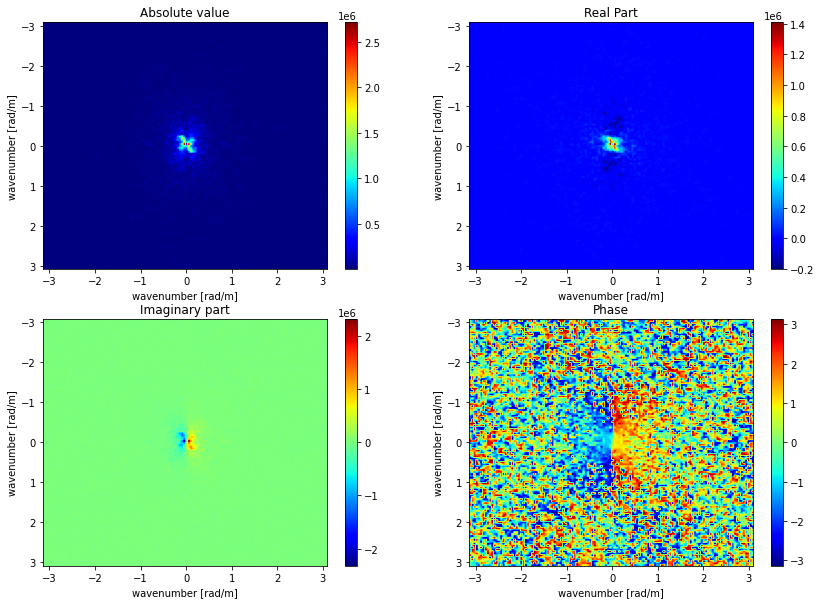

In [54]:
ground_spacing = 1

kran = (np.arange(periodo_size)-periodo_size/2.)/periodo_size*2*np.pi/ground_spacing
kazi = (np.arange(periodo_size)-periodo_size/2.)/periodo_size*2*np.pi/ground_spacing
fig = plt.figure(figsize = (14,10))
plt.subplot(2, 2, 1)
plt.imshow(np.flipud(np.abs(spec)*1e5), extent=[kran[0], kran[-1],
            kazi[-1], kazi[1]], aspect='auto',cmap='jet')
plt.xlabel('wavenumber [rad/m]')
plt.ylabel('wavenumber [rad/m]')
plt.title('Absolute value')
plt.colorbar()
plt.subplot(2, 2, 2)
plt.imshow(np.flipud(np.real(spec)*1e5), extent=[kran[0], kran[-1],
            kazi[-1], kazi[1]],aspect='auto',cmap='jet')
plt.xlabel('wavenumber [rad/m]')
plt.ylabel('wavenumber [rad/m]')
plt.title('Real Part')
plt.colorbar()
plt.subplot(2, 2, 3)
plt.imshow(np.flipud(np.imag(spec)*1e5), extent=[kran[0], kran[-1],
            kazi[-1], kazi[1]],aspect='auto',cmap='jet')
plt.xlabel('wavenumber [rad/m]')
plt.ylabel('wavenumber [rad/m]')
plt.title('Imaginary part')
plt.colorbar()
plt.subplot(2, 2, 4)
plt.imshow(np.flipud(np.angle(spec)), extent=[kran[0], kran[-1],
           kazi[-1], kazi[1]],aspect='auto',cmap='jet')
plt.xlabel('wavenumber [rad/m]')
plt.ylabel('wavenumber [rad/m]')
plt.title('Phase')
plt.colorbar()

plt.savefig('spectra.png',dpi=300)

Text(0, 0.5, 'm/s')

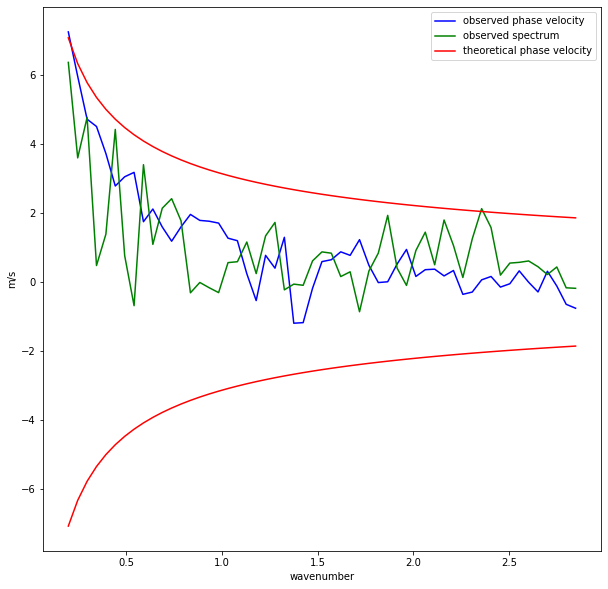

In [31]:
fig = plt.figure(figsize = (10,10))
shift_time_bands = 1

mini = int(periodo_size/2+4)
spec = looks2xspec(data1, data2,periodo_size)
vphase = np.angle(np.mean(spec[:,mini:-5],axis=0)) / kran[mini:-5] / shift_time_bands
sp = np.mean(np.real(spec[:,mini:-5]),axis=0)/np.mean(np.real(spec[:,mini:-5]))
plt.plot(kran[mini:-5],vphase, 'b', label='observed phase velocity')
plt.plot(kran[mini:-5],sp, 'g', label='observed spectrum')
plt.plot(kran[mini:-5],np.sqrt(9.81/kran[mini:-5]), 'r', label='theoretical phase velocity')
plt.plot(kran[mini:-5],-np.sqrt(9.81/kran[mini:-5]), 'r')

plt.legend()
plt.xlabel('wavenumber')
plt.ylabel('m/s')
